In [ ]:
# pip install xgboost
# pip install ucimlrepo

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

# 학습데이터 구성 및 전처리
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# 랜덤포레스트
from sklearn.ensemble import RandomForestClassifier

# Xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree

# XAI
import shap

# 학습 데이터원천
from ucimlrepo import fetch_ucirepo

# 평가지표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# 데이터 로드
# https://archive.ics.uci.edu/dataset
wine_quality = fetch_ucirepo(id=186)



In [24]:
X = wine_quality.data.features
y = wine_quality.data.targets

# metadata
# dataset에 대한 정보
print(wine_quality.metadata)
# variable에 대한 정보
print(wine_quality.variables)

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'title': 'Modeling wine preferences by data mining from physicoc

In [15]:
# EDA (탐색적 데이터 분석)

print("Data shape", X.shape)
print("Target Distribution: \n", y.value_counts())

Data shape (6497, 11)
Target Distribution: 
 quality
6          2836
5          2138
7          1079
4           216
8           193
3            30
9             5
Name: count, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_22236\3121753340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = y


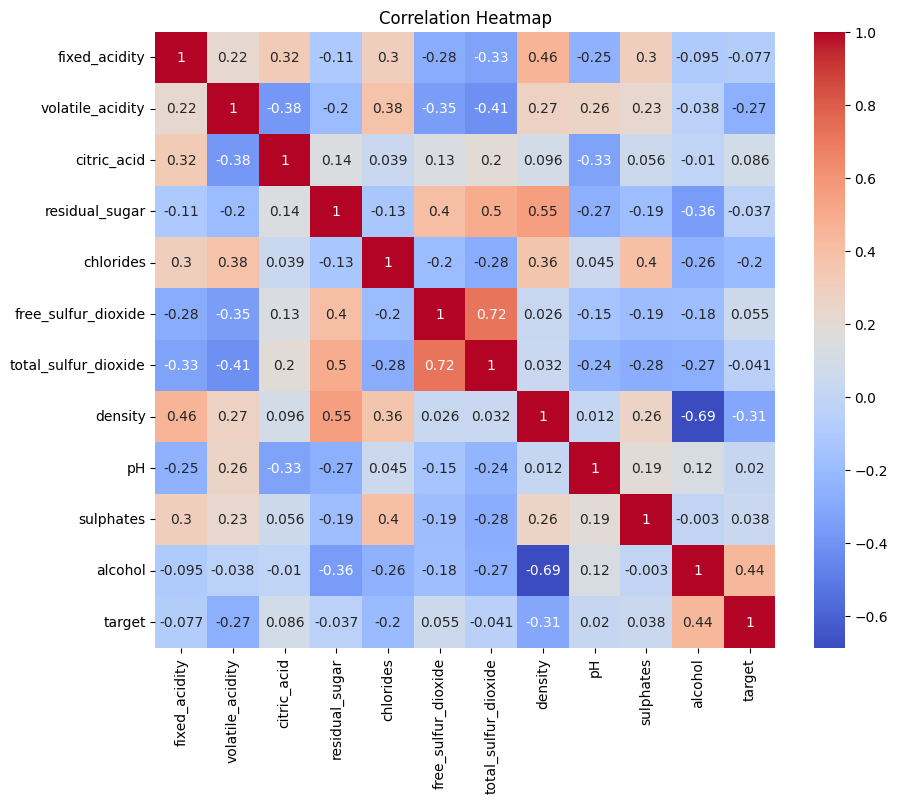

In [17]:
#히트맵 시각화
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap= 'coolwarm')
plt.title("Correlation Heatmap")
plt.show()

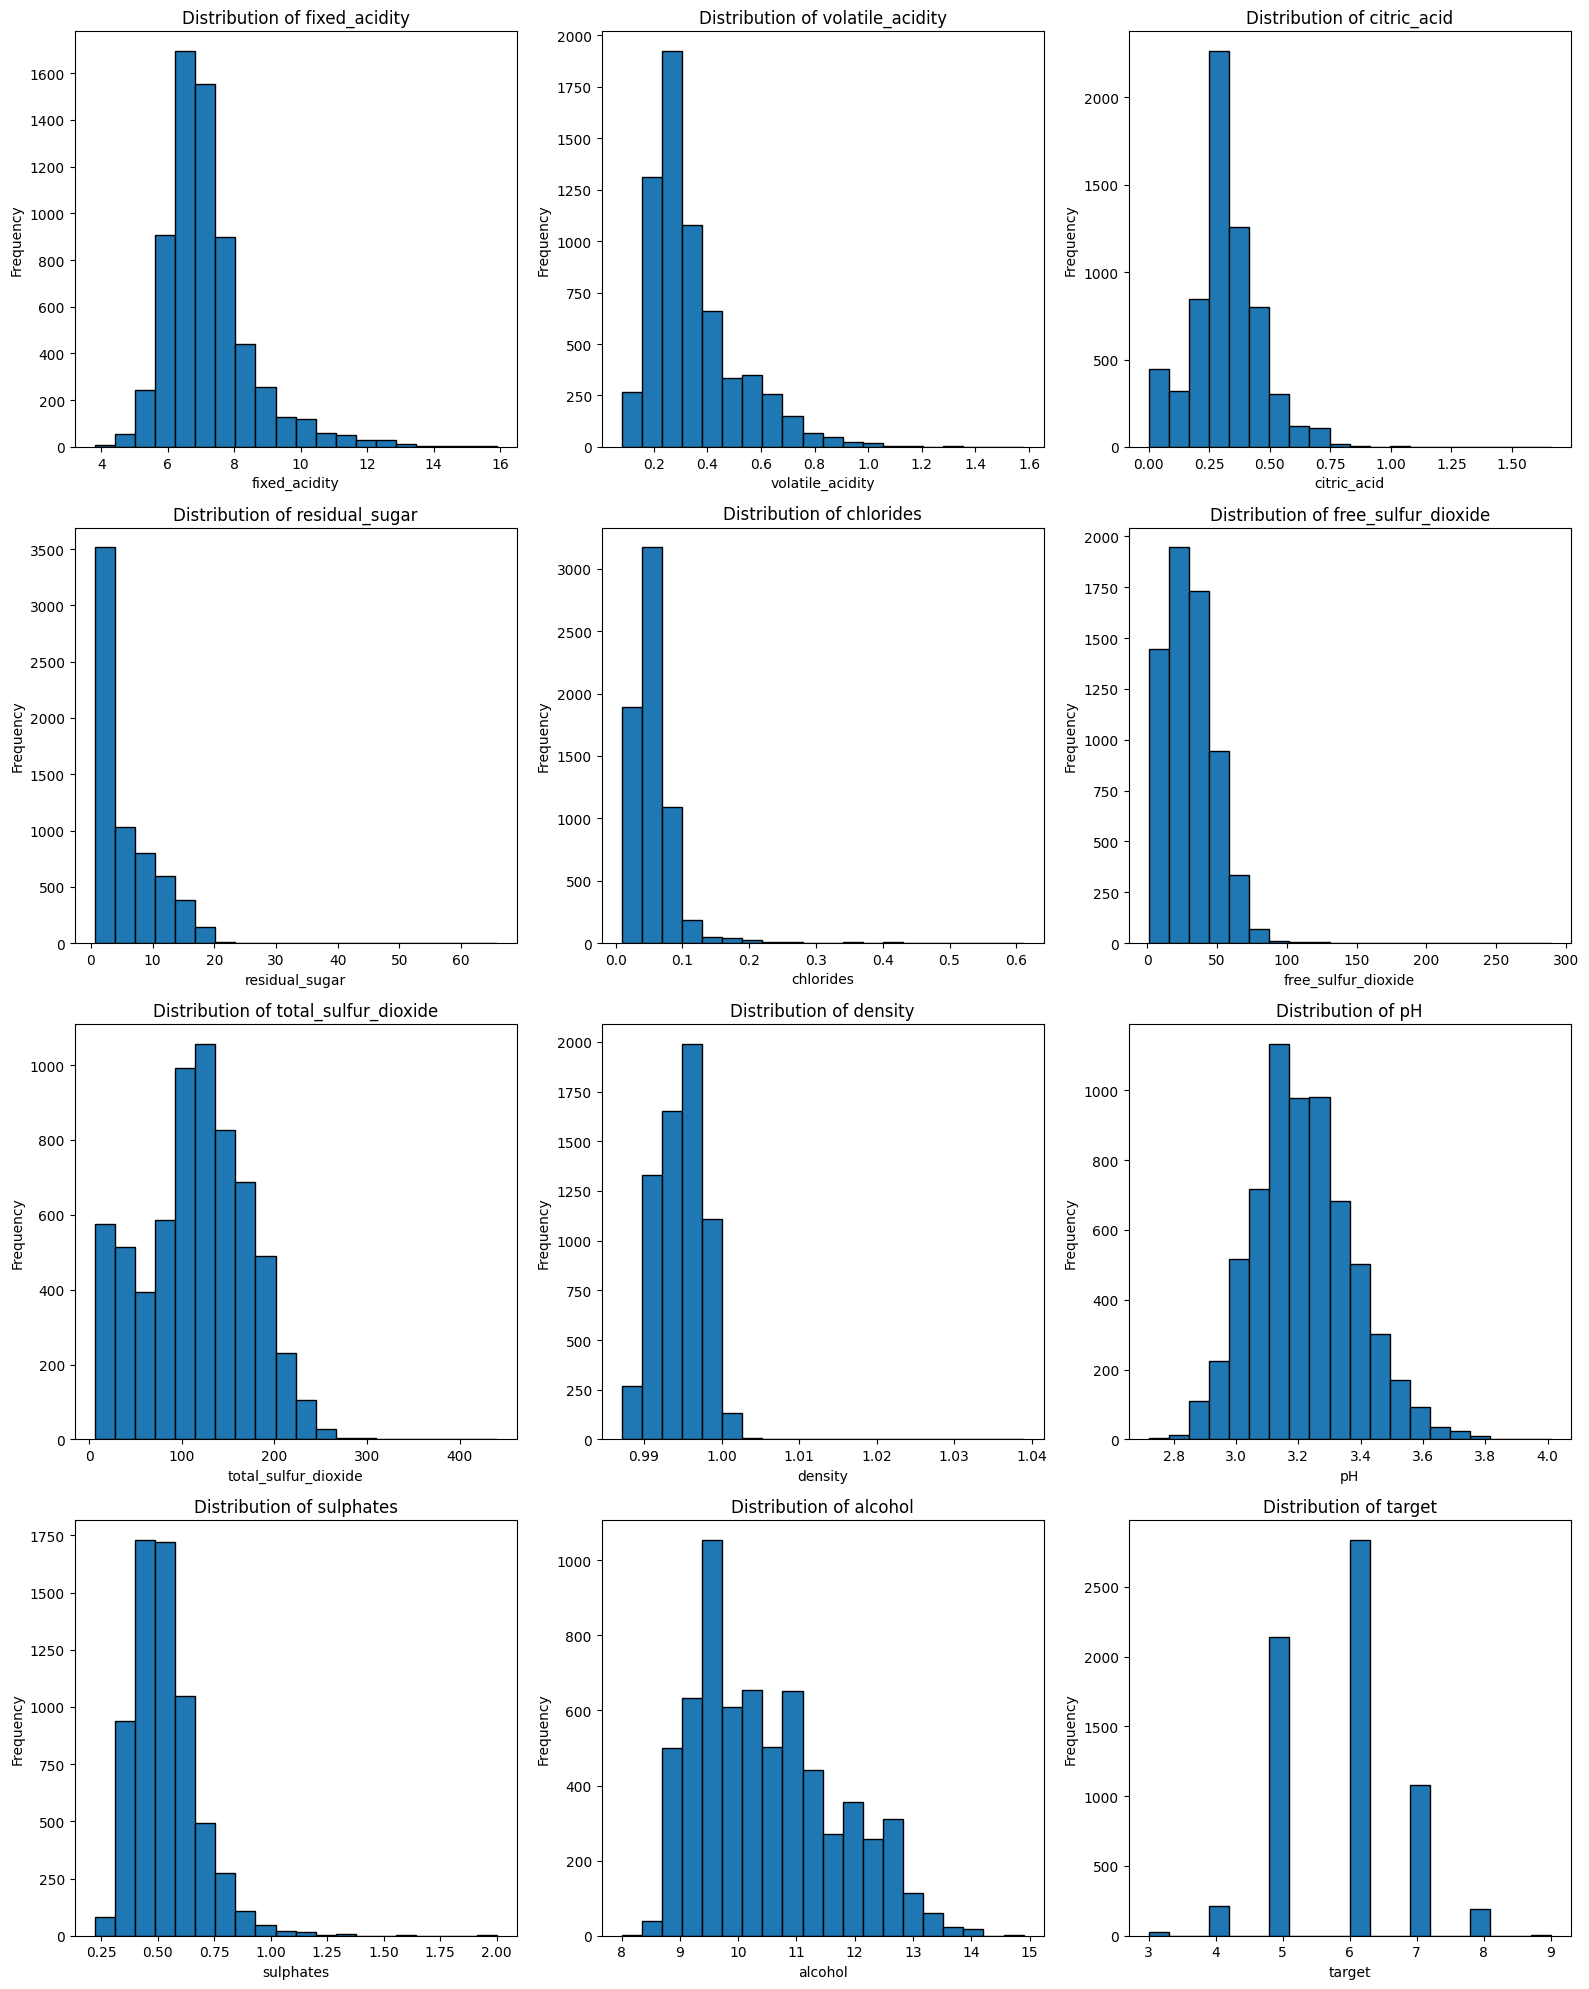

In [18]:
# Feature 분포 시각화
plt.figure(figsize=(16, 20))

for i, feature in enumerate(X.columns):
    plt.subplot(4, 3, i+1)
    plt.hist(X[feature], bins = 20, edgecolor='black' )
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

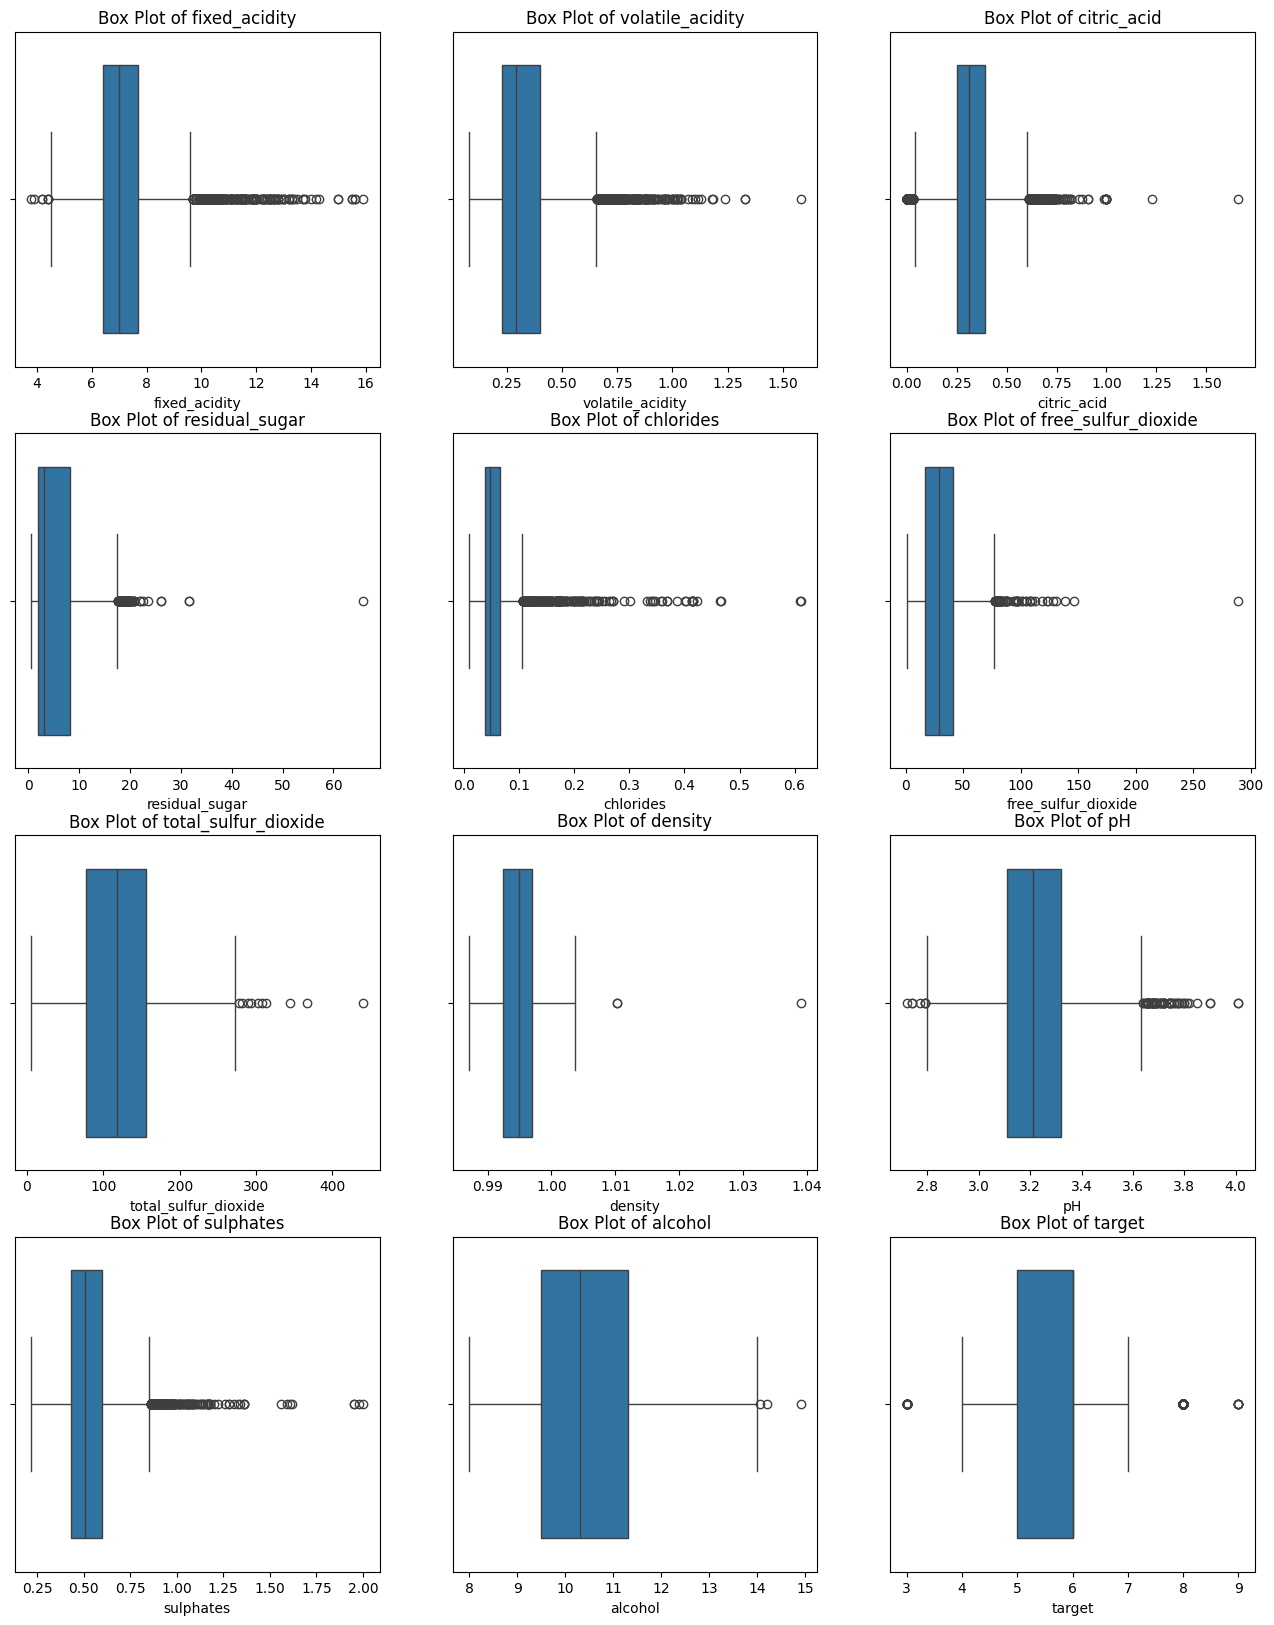

In [21]:
# Box-plot
plt.figure(figsize=(16, 20))

for i, feature in enumerate(X.columns):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x=X[feature])
    plt.title(f"Box Plot of {feature}")

plt.tight_layout
plt.show()

In [35]:
X = df.drop('target', axis=1)

In [36]:
# 데이터 전처리
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# 클래스 레이블 확인
unique_labels = np.unique(y)
print(unique_labels)

[3 4 5 6 7 8 9]


In [42]:
# 레이블링 인코딩

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [45]:
# Random Forest 모델 생성 및 학습

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train_encoded)

RandomForestClassifier(random_state=42)

In [46]:
# Random Forest 모델 예측

rf_y_pred_encoded = rf_model.predict(X_test)
rf_y_pred = label_encoder.inverse_transform(rf_y_pred_encoded)

print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.71      0.12      0.20        43
           5       0.67      0.71      0.69       402
           6       0.66      0.75      0.70       597
           7       0.71      0.55      0.62       215
           8       0.92      0.33      0.49        36
           9       0.00      0.00      0.00         1

    accuracy                           0.67      1300
   macro avg       0.52      0.35      0.39      1300
weighted avg       0.67      0.67      0.66      1300



c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [47]:
# XGboost 모델 생성 및 학습

xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [48]:
# 예측 및 레이블 디코딩

rf_y_pred_encoded = xgb_model.predict(X_test)
y_pred = label_encoder.inverse_transform(rf_y_pred_encoded)

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.42      0.19      0.26        43
           5       0.66      0.71      0.68       402
           6       0.67      0.73      0.70       597
           7       0.65      0.57      0.61       215
           8       0.72      0.36      0.48        36
           9       0.00      0.00      0.00         1

    accuracy                           0.66      1300
   macro avg       0.45      0.36      0.39      1300
weighted avg       0.65      0.66      0.65      1300



c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [52]:
print("XGboost Hyperparemeters:")
# print(xgb_model.get_params())


pprint.pprint(xgb_model.get_params())

XGboost Hyperparemeters:
{'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'multi:softprob',
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}


In [53]:
# 하이퍼파라미터 범위지정

params = {
    "max_depth" : [3, 5, 7, 9, 15],
    "learning_rate" : [0.1, 0.01, 0.001],
    "n_estimators": [50, 100, 200, 300]
}

In [54]:
# 하이퍼파라미터 최적화 
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train_encoded)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:" , grid_search.best_score_)


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 200}
Best accuracy: 0.6638468942030059


In [57]:
## 최적의 하이퍼파라미터의 학습

best_model = grid_search.best_estimator_

#테스트 데이터에 대한 예측
y_pred_encoded = best_model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.56      0.23      0.33        43
           5       0.67      0.69      0.68       402
           6       0.66      0.74      0.69       597
           7       0.69      0.56      0.62       215
           8       0.78      0.39      0.52        36
           9       0.00      0.00      0.00         1

    accuracy                           0.66      1300
   macro avg       0.48      0.37      0.41      1300
weighted avg       0.66      0.66      0.66      1300



c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

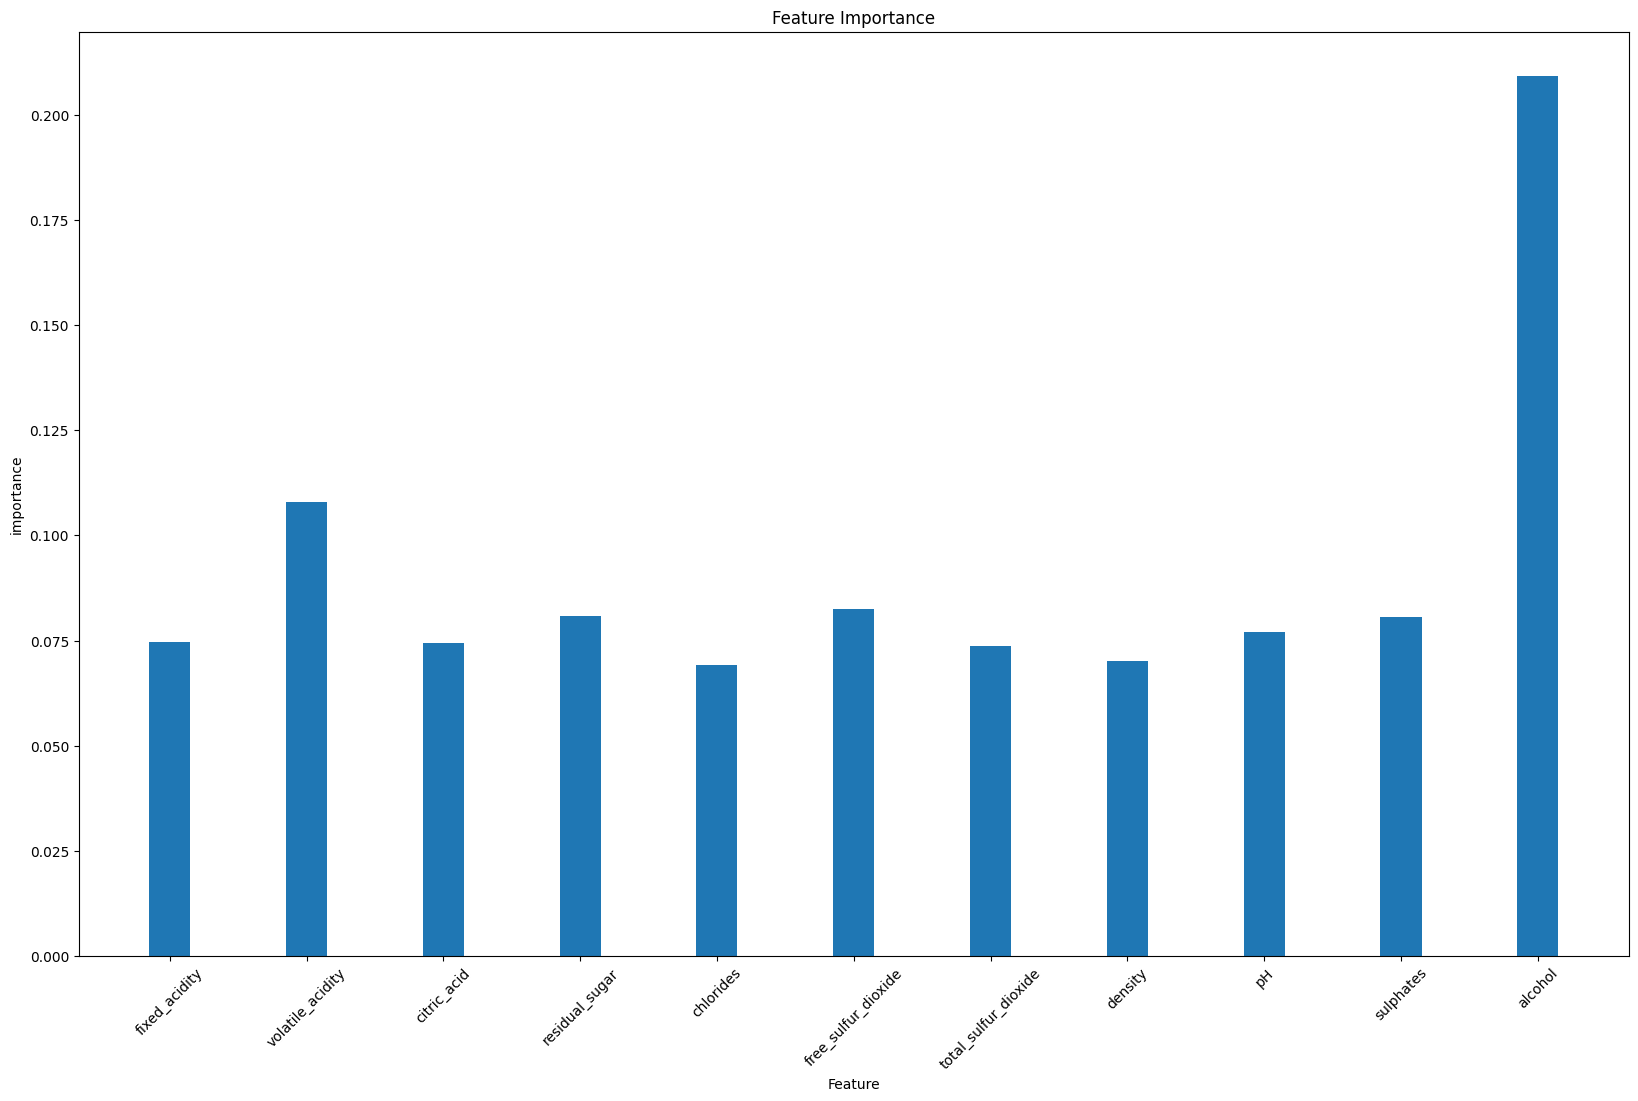

In [59]:
# XAI
# Feature Importance 시각화
importances = best_model.feature_importances_

plt.figure(figsize= (20,12))
#막대그래프 생성
plt.bar(range(len(importances)), importances, width= 0.3)
plt.xlabel('Feature')
plt.ylabel('importance')
plt.title('Feature Importance')
plt.xticks(range(len(importances)), X.columns, rotation =45)
plt.show()

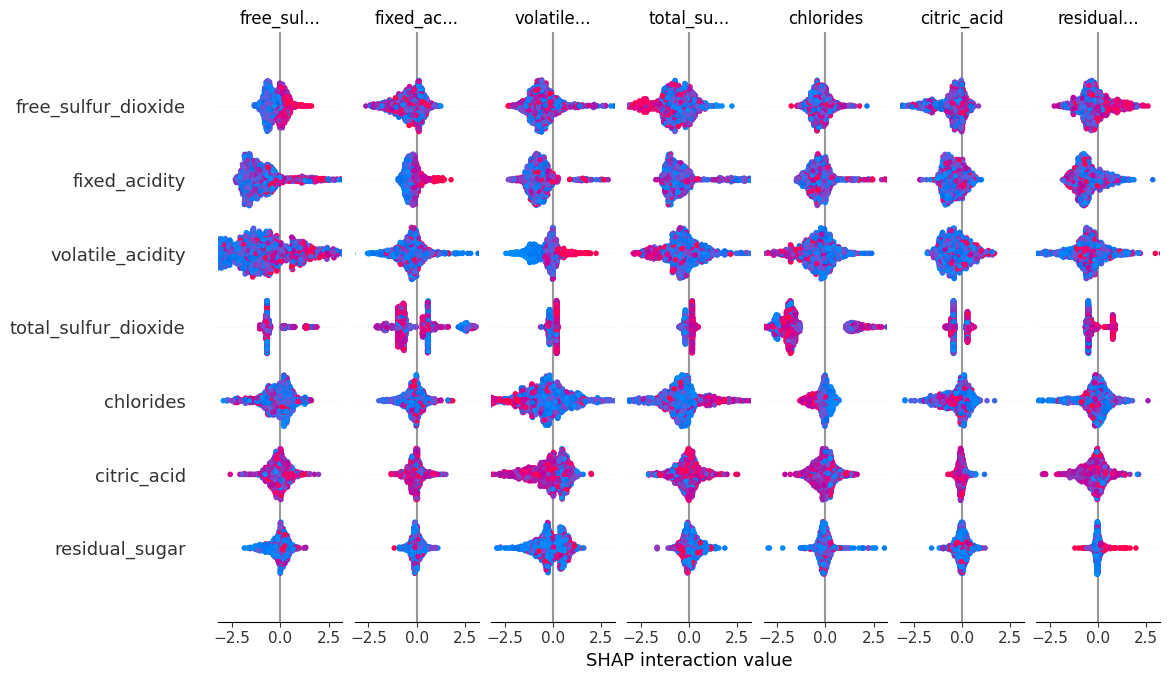

In [61]:
# XAI
# SHAP (Shapley Additive Explanations)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X.columns)

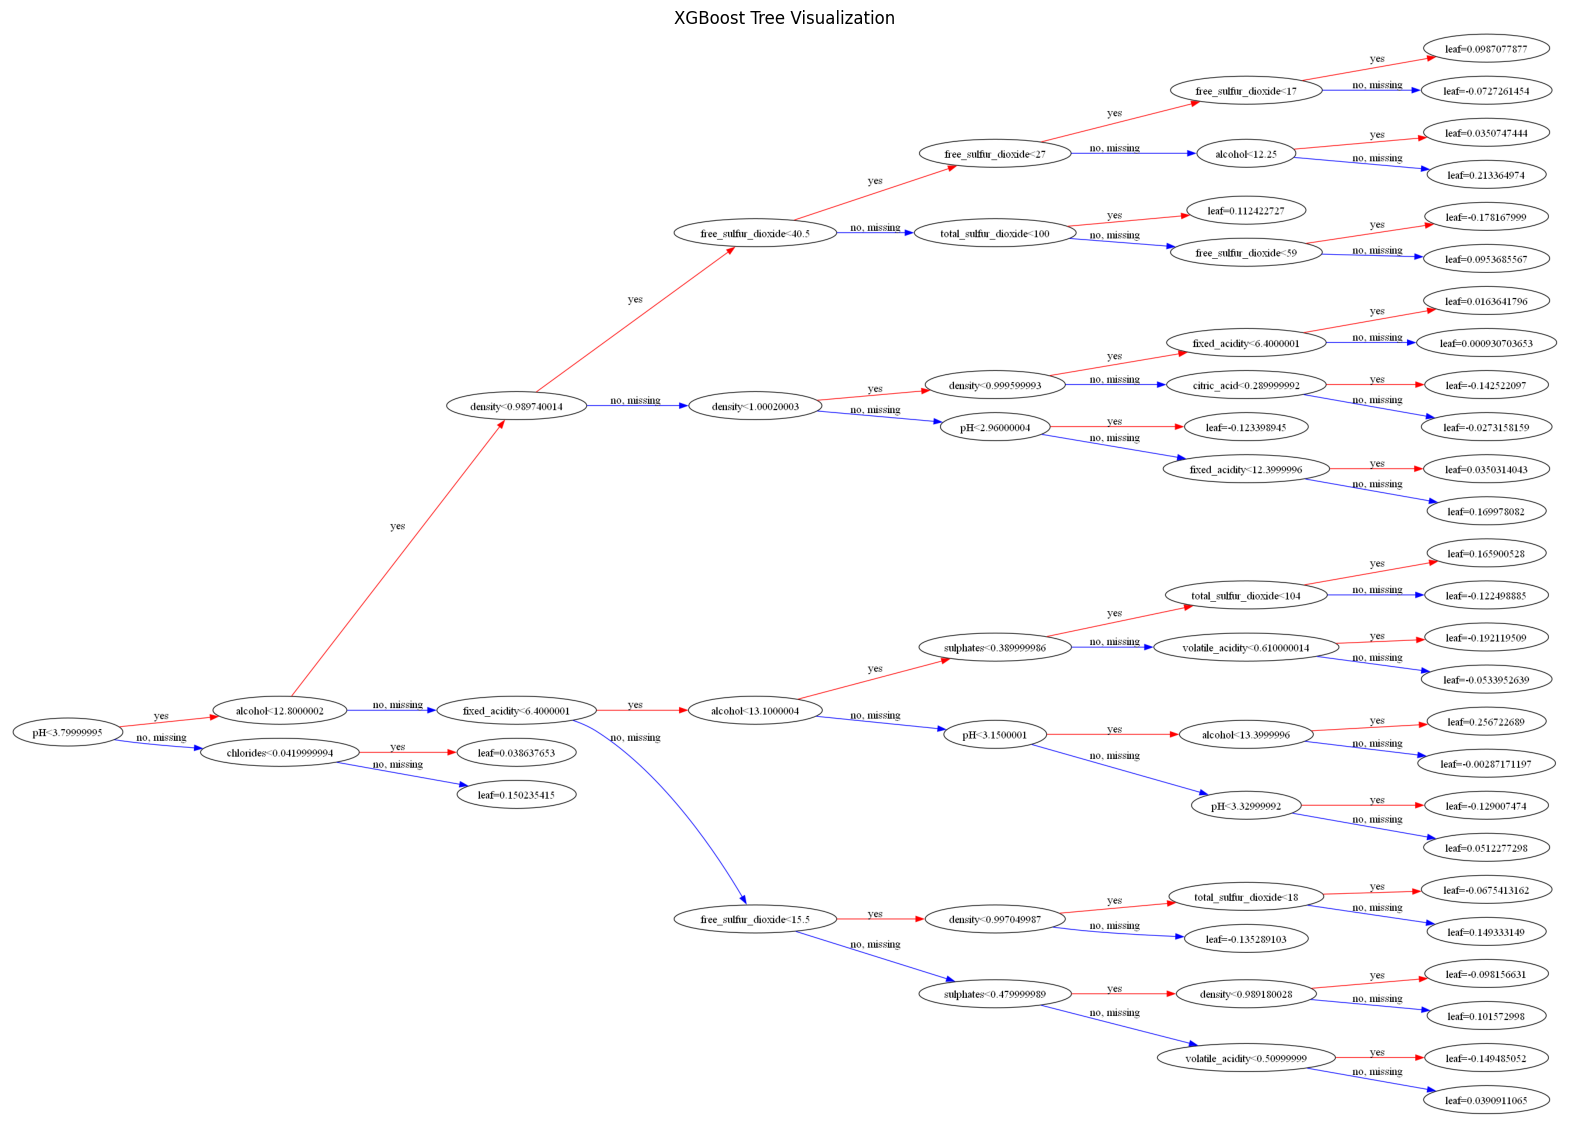

In [67]:
# XGboost 트리 시각화

fig, ax = plt.subplots(figsize = (20, 20))
plot_tree(xgb_model, num_trees=150, rankdir='LR', ax=ax)

plt.title("XGBoost Tree Visualization")
plt.show()